In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook')
import corner
from tqdm.auto import tqdm  # notebook friendly
import glob
import arviz as az

from agnfinder.prospector.main import load_catalog
from agnfinder.prospector import load_photometry
from agnfinder import simulation_samples, simulation_utils
from agnfinder.tf_sampling import parameter_recovery, percentile_limits, hmc

In [3]:
from scipy import stats

In [4]:
os.chdir('/home/walml/repos/agnfinder')

### Let's have a go with fake data to develop the algorithm

In [5]:
def truncated_normal_samples(mu, std, n_samples=1000): # 0->1 range
    min_val = 0.
    max_val = 1.
    a, b = (min_val - mu) / std, (max_val - mu) / std
    return stats.truncnorm(a, b, loc=mu, scale=std).rvs(n_samples)

In [6]:
n_galaxies = 1000
mu = np.linspace(0.1, 0.9, n_galaxies)
std = 0.05
true_values = np.array([truncated_normal_samples(x, std, n_samples=1) for x in mu]).squeeze()
posteriors = np.array([truncated_normal_samples(x, std) for x in mu])
true_values.shape, posteriors.shape

((1000,), (1000, 1000))

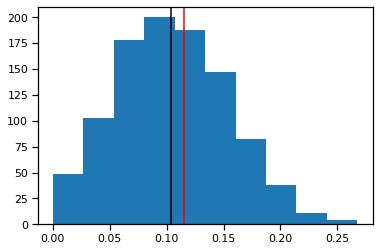

In [7]:
n = 5
plt.hist(posteriors[n, :])
plt.axvline(mu[n], color='k')
plt.axvline(true_values[n], color='r')


In [8]:
def get_hpd(x, ci=0.8):  # TODO assumes a clear MLE exists - should throw error if not
    if len(x) == 0:
        return np.array([np.nan, np.nan])
#     https://arviz-devs.github.io/arviz/generated/arviz.hpd.html
    return az.hpd(x[~np.isnan(x)], credible_interval=ci, multimodal=True)  # may return multiple ci's for multiple modes

[[0.03557786 0.39690669]
 [0.58760802 0.97402912]]


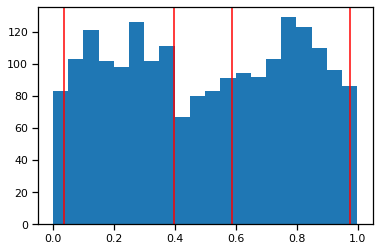

In [9]:
multimodal_samples = np.concatenate([truncated_normal_samples(0.2, 0.2, 1000), truncated_normal_samples(0.8, 0.2, 1000)])
modes = get_hpd(multimodal_samples)
print(modes)
plt.hist(multimodal_samples, bins=20)
for mode in modes:
    plt.axvline(mode[0], color='r')
    plt.axvline(mode[1], color='r')

In [10]:
def get_coverage(posteriors, true_values):
    results = []
    for ci_width in np.linspace(0.1, 0.95):
        for target_n, posterior in enumerate(posteriors):
            true_value = true_values[target_n]
            credible_interval_width = 0.8
            modes = get_hpd(posterior, ci=ci_width)
            within_any_ci = any([x[0] < true_value < x[1] for x in modes])
            results.append({
                'ci_width': ci_width,
#                 'hpd_min': hpd[0],
#                 'hpd_max': hpd[1],
                'true_value': true_value,
                'true_within_hpd': within_any_ci
            })
    return pd.DataFrame(results)

In [11]:
df = get_coverage(posteriors, true_values)
df.head()

,ci_width,true_value,true_within_hpd
0,0.1,0.150170,False
1,0.1,0.122124,False
2,0.1,0.043388,False
3,0.1,0.063106,False
4,0.1,0.064277,False


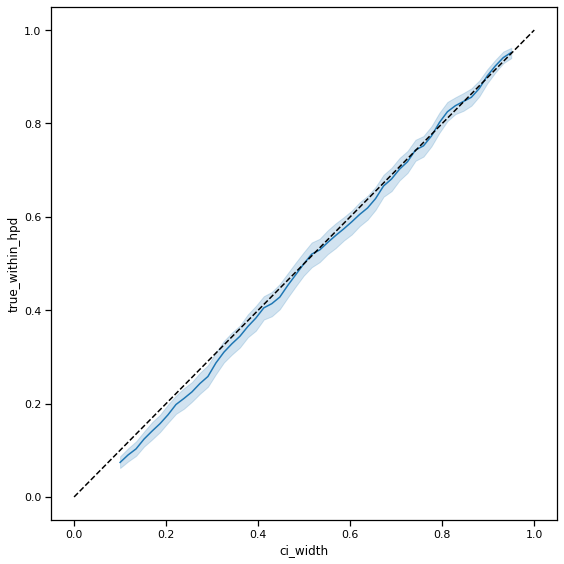

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.lineplot(data=df, x='ci_width', y='true_within_hpd', ax=ax, ci=90)
ax.plot([0, 1.], [0, 1.], 'k--')
fig.tight_layout()
# This the same as my manual version below

In [13]:
def get_error_coverage(posteriors, true_values):
    results = []
    for error in np.linspace(0.01, 0.2):
        for obs_n, posterior in enumerate(posteriors):
            # simply to check unimodal
            modes = get_hpd(posterior)
            if len(modes) > 1:
                continue  # skip multimodal
            best_guess = np.median(posterior)
            lower_lim = np.max([0, best_guess - error])
            upper_lim = np.min([1, best_guess + error])
            assert lower_lim <= upper_lim
            posterior_frac = np.mean((lower_lim <= posterior) & (posterior <= upper_lim))
            true_is_within = lower_lim < true_values[obs_n] < upper_lim
            results.append(
                {
                    'error': error,
                    'lower_lim': lower_lim,
                    'best_guess': best_guess,
                    'posterior_frac': posterior_frac,
                    'true_is_within': true_is_within
                }
            )
    return pd.DataFrame(results)

In [14]:
error_df = get_error_coverage(posteriors, true_values)

In [15]:
error_df.head()

,error,lower_lim,best_guess,posterior_frac,true_is_within
0,0.01,0.089677,0.099677,0.162,False
1,0.01,0.091322,0.101322,0.175,False
2,0.01,0.089553,0.099553,0.176,False
3,0.01,0.094035,0.104035,0.175,False
4,0.01,0.091824,0.101824,0.154,False


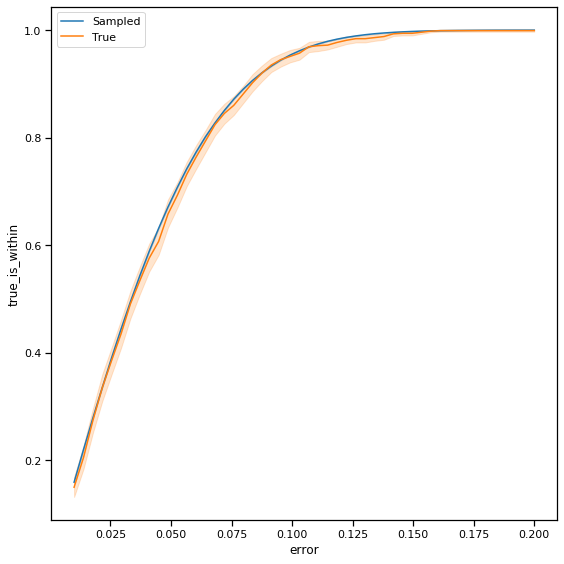

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.lineplot(data=error_df, x='error', y='posterior_frac', ax=ax, ci=90, label='Sampled')
sns.lineplot(data=error_df, x='error', y='true_is_within', ax=ax, ci=90, label='True')
# ax.plot([0, 1.], [0, 1.], 'k--')
fig.tight_layout()
# This the same as my manual version below

In [17]:
# courtesy of http://www.jtrive.com/the-empirical-bootstrap-for-confidence-intervals-in-python.html
def bootstrap(data, n=1000, func=np.mean):
    """
    Generate `n` bootstrap samples, evaluating `func`
    at each resampling. `bootstrap` returns a function,
    which can be called to obtain confidence intervals
    of interest.
    """
    simulations = list()
    sample_size = len(data)
    xbar_init = np.mean(data)
    for c in range(n):
        itersample = np.random.choice(data, size=sample_size, replace=True)
        simulations.append(func(itersample))
    simulations.sort()
    def ci(p):
        """
        Return 2-sided symmetric confidence interval specified
        by p.
        """
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        return(simulations[l_indx],simulations[u_indx])
    return(ci)


In [18]:
def aggregate_coverage_df(df):
    temp = df.copy()
    # duplicate the useful column, use one copy for the uncertainty
    temp['observed_rate'] = temp['true_within_hpd']
    temp['observed_rate_unc'] = temp['true_within_hpd']
    coverage = temp.groupby('ci_width').agg({'observed_rate': 'mean', 'observed_rate_unc': lambda x: bootstrap(x)(.9)}).reset_index()
    coverage['observed_rate_min'] = coverage['observed_rate_unc'].apply(lambda x: x[0])
    coverage['observed_rate_max'] = coverage['observed_rate_unc'].apply(lambda x: x[1])
    return coverage

In [19]:
def aggregate_error_coverage_df(df):
    temp = df.copy()
    # duplicate the useful column, use one copy for the uncertainty
    temp['posterior_frac_unc'] = temp['posterior_frac']
    coverage = temp.groupby('error').agg({'posterior_frac': 'mean', 'posterior_frac_unc': lambda x: bootstrap(x)(.9)}).reset_index()
    coverage['observed_rate_min'] = coverage['posterior_frac_unc'].apply(lambda x: x[0])
    coverage['observed_rate_max'] = coverage['posterior_frac_unc'].apply(lambda x: x[1])
    return coverage

In [20]:
coverage = aggregate_coverage_df(df)
coverage.head()

 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:Mean of empty slice.
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:invalid value encountered in double_scalars


,ci_width,observed_rate,observed_rate_unc,observed_rate_min,observed_rate_max
0,0.100000,0.074,"(0.06, 0.088)",0.060,0.088
1,0.117347,0.090,"(0.075, 0.106)",0.075,0.106
2,0.134694,0.103,"(0.088, 0.119)",0.088,0.119
3,0.152041,0.124,"(0.106, 0.142)",0.106,0.142
4,0.169388,0.141,"(0.124, 0.158)",0.124,0.158


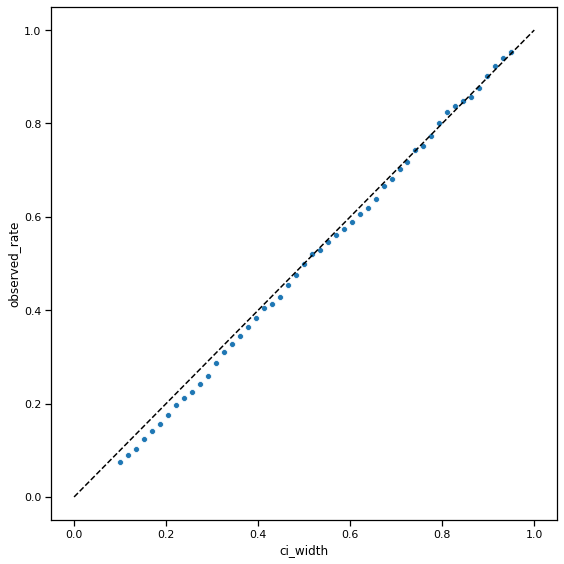

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=coverage, x='ci_width', y='observed_rate', ax=ax)
ax.plot([0, 1.], [0, 1.], 'k--')
fig.tight_layout()

In [22]:
def plot_coverage(df):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(df['ci_width'], df['observed_rate'])
    ax.fill_between(x=df['ci_width'], y1=df['observed_rate_min'], y2=df['observed_rate_max'], alpha=0.5)
    ax.plot([0, 1.], [0, 1.], 'k--')
    fig.tight_layout()
    return fig, ax

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faf96ab4610>)

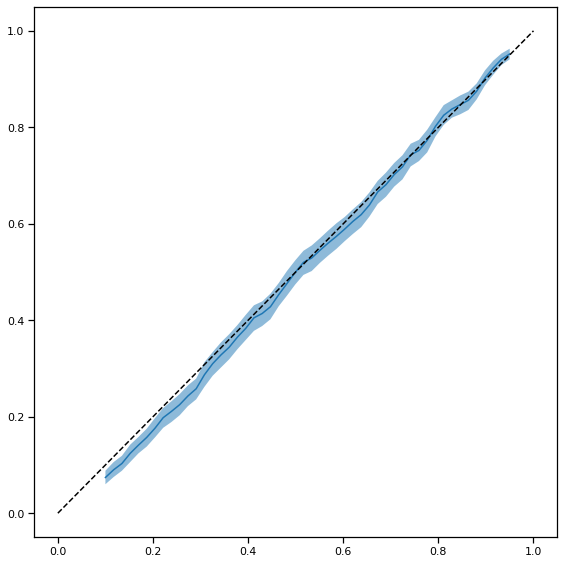

In [23]:
plot_coverage(coverage)

In [24]:
coverage = aggregate_error_coverage_df(error_df)
coverage.head()

 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:Mean of empty slice.
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:invalid value encountered in double_scalars


,error,posterior_frac,posterior_frac_unc,observed_rate_min,observed_rate_max
0,0.010000,0.159315,"(0.158736, 0.15992699999999996)",0.158736,0.159927
1,0.013878,0.219861,"(0.219206, 0.22054400000000005)",0.219206,0.220544
2,0.017755,0.278824,"(0.278101, 0.279584)",0.278101,0.279584
3,0.021633,0.335547,"(0.33475, 0.3363190000000001)",0.334750,0.336319
4,0.025510,0.390987,"(0.39015999999999995, 0.391877)",0.390160,0.391877


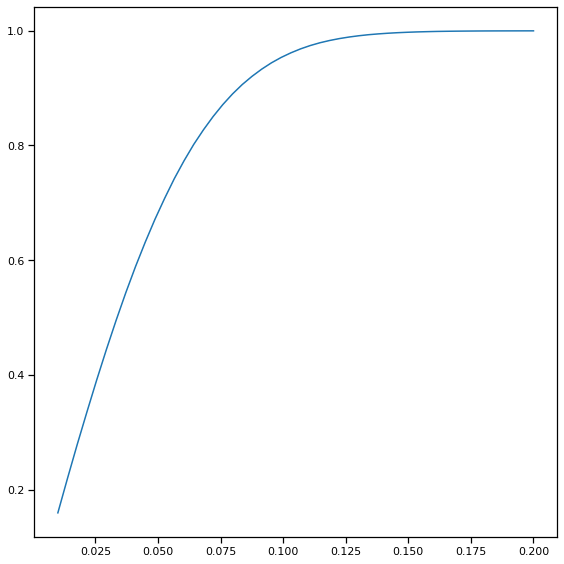

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(coverage['error'], coverage['posterior_frac'])
ax.fill_between(x=coverage['error'], y1=coverage['observed_rate_min'], y2=coverage['observed_rate_max'], alpha=0.5)
# ax.plot([0, 1.], [0, 1.], 'k--')
fig.tight_layout()

Coverage seems to work quite well with 1k galaxies, 1k samples, simple distribution, but tends towards mild overconfidence as the available data reduces. I wonder if this is expected?

In [26]:
# assert False

## Real galaxies

In [33]:
# save_dir = 'results/emulated_sampling/latest_emcee_5000_10000_1_optimised'
# save_dir = 'results/emulated_sampling/latest_hmc_10000_30000_16_optimised'
# save_dir = 'results/emulated_sampling/latest_hmc_10000_40000_8_optimised'
# all_galaxy_locs = glob.glob(save_dir + '/galaxy*.h5')
# hmc_galaxy_indices = set([x.split('_')[-3] for x in all_galaxy_locs])
# assert all_galaxy_locs

save_dir = 'results/vanilla_emcee'
all_galaxy_locs = glob.glob(save_dir + '/*samples*.h5')
emcee_galaxy_indices = set([x.split('_')[-4] for x in all_galaxy_locs])

assert all_galaxy_locs




In [34]:
max_redshift = 4.0
n_param_bins = 50
n_posterior_bins = 50  # or will have to remake marginals

### run this block a few times to load each set of samples

In [35]:
# save_dir = 'results/emulated_sampling/latest_hmc_10000_40000_8_optimised'
save_dir = 'results/vanilla_emcee'
# save_dir = 'results/emulated_sampling/latest_emcee_5000_20000_1_optimised'

In [58]:
    
posteriors_all_params_emcee = None
true_params_emcee = None
posteriors_all_params_hmc = None
true_params_hmc = None

In [37]:
params, marginals, true_params, samples = parameter_recovery.load_samples(save_dir, False, max_redshift, frac_to_load=1000)
len(samples), len(true_params)


310 galaxies loaded [00:00, 5841.15 galaxies loaded/s]

0 galaxies loaded [00:00, ? galaxies loaded/s]
1 galaxies loaded [00:00,  2.88 galaxies loaded/s]

Using scale bins for param n 8



2 galaxies loaded [00:00,  2.84 galaxies loaded/s]

Using scale bins for param n 8



3 galaxies loaded [00:01,  2.80 galaxies loaded/s]

Using scale bins for param n 8



4 galaxies loaded [00:01,  2.80 galaxies loaded/s]

Using scale bins for param n 8



5 galaxies loaded [00:01,  2.79 galaxies loaded/s]

Using scale bins for param n 8



6 galaxies loaded [00:02,  2.74 galaxies loaded/s]

Using scale bins for param n 8



7 galaxies loaded [00:02,  2.76 galaxies loaded/s]

Using scale bins for param n 8



8 galaxies loaded [00:02,  2.77 galaxies loaded/s]

Using scale bins for param n 8



9 galaxies loaded [00:03,  2.80 galaxies loaded/s]

Using scale bins for param n 8



10 galaxies loaded [00:03,  2.82 galaxies loaded/s]

Using scale bins for param n 8



11 galaxies loaded [00:03,  2.75 galaxies loaded/s]

Using scale bins for param n 8



12 galaxies loaded [00:04,  2.67 galaxies loaded/s]

Using scale bins for param n 8



13 galaxies loaded [00:04,  2.67 galaxies loaded/s]

Using scale bins for param n 8



14 galaxies loaded [00:05,  2.70 galaxies loaded/s]

Using scale bins for param n 8



15 galaxies loaded [00:05,  2.66 galaxies loaded/s]

Using scale bins for param n 8



16 galaxies loaded [00:05,  2.58 galaxies loaded/s]

Using scale bins for param n 8



17 galaxies loaded [00:06,  2.58 galaxies loaded/s]

Using scale bins for param n 8



18 galaxies loaded [00:06,  2.60 galaxies loaded/s]

Using scale bins for param n 8



19 galaxies loaded [00:07,  2.64 galaxies loaded/s]

Using scale bins for param n 8



20 galaxies loaded [00:07,  2.69 galaxies loaded/s]

Using scale bins for param n 8



21 galaxies loaded [00:07,  2.68 galaxies loaded/s]

Using scale bins for param n 8



22 galaxies loaded [00:08,  2.63 galaxies loaded/s]

Using scale bins for param n 8



23 galaxies loaded [00:08,  2.59 galaxies loaded/s]

Using scale bins for param n 8



24 galaxies loaded [00:08,  2.58 galaxies loaded/s]

Using scale bins for param n 8



25 galaxies loaded [00:09,  2.65 galaxies loaded/s]

Using scale bins for param n 8



26 galaxies loaded [00:09,  2.65 galaxies loaded/s]

Using scale bins for param n 8



27 galaxies loaded [00:10,  2.65 galaxies loaded/s]

Using scale bins for param n 8



28 galaxies loaded [00:10,  2.62 galaxies loaded/s]

Using scale bins for param n 8



29 galaxies loaded [00:10,  2.55 galaxies loaded/s]

Using scale bins for param n 8



30 galaxies loaded [00:11,  2.59 galaxies loaded/s]

Using scale bins for param n 8



31 galaxies loaded [00:11,  2.63 galaxies loaded/s]

Using scale bins for param n 8



32 galaxies loaded [00:11,  2.64 galaxies loaded/s]

Using scale bins for param n 8



33 galaxies loaded [00:12,  2.62 galaxies loaded/s]

Using scale bins for param n 8



34 galaxies loaded [00:12,  2.61 galaxies loaded/s]

Using scale bins for param n 8



35 galaxies loaded [00:13,  2.59 galaxies loaded/s]

Using scale bins for param n 8



36 galaxies loaded [00:13,  2.57 galaxies loaded/s]

Using scale bins for param n 8



37 galaxies loaded [00:13,  2.58 galaxies loaded/s]

Using scale bins for param n 8



38 galaxies loaded [00:14,  2.58 galaxies loaded/s]

Using scale bins for param n 8



39 galaxies loaded [00:14,  2.66 galaxies loaded/s]

Using scale bins for param n 8



40 galaxies loaded [00:15,  2.65 galaxies loaded/s]

Using scale bins for param n 8



41 galaxies loaded [00:15,  2.74 galaxies loaded/s]

Using scale bins for param n 8



42 galaxies loaded [00:15,  2.80 galaxies loaded/s]

Using scale bins for param n 8



43 galaxies loaded [00:16,  2.81 galaxies loaded/s]

Using scale bins for param n 8



44 galaxies loaded [00:16,  2.78 galaxies loaded/s]

Using scale bins for param n 8



45 galaxies loaded [00:16,  2.80 galaxies loaded/s]

Using scale bins for param n 8



46 galaxies loaded [00:17,  2.85 galaxies loaded/s]

Using scale bins for param n 8



47 galaxies loaded [00:17,  2.84 galaxies loaded/s]

Using scale bins for param n 8



48 galaxies loaded [00:17,  2.83 galaxies loaded/s]

Using scale bins for param n 8



49 galaxies loaded [00:18,  2.85 galaxies loaded/s]

Using scale bins for param n 8



50 galaxies loaded [00:18,  2.86 galaxies loaded/s]

Using scale bins for param n 8



51 galaxies loaded [00:18,  2.84 galaxies loaded/s]

Using scale bins for param n 8



52 galaxies loaded [00:19,  2.74 galaxies loaded/s]

Using scale bins for param n 8



53 galaxies loaded [00:19,  2.73 galaxies loaded/s]

Using scale bins for param n 8



54 galaxies loaded [00:20,  2.75 galaxies loaded/s]

Using scale bins for param n 8



55 galaxies loaded [00:20,  2.80 galaxies loaded/s]

Using scale bins for param n 8



56 galaxies loaded [00:20,  2.84 galaxies loaded/s]

Using scale bins for param n 8



57 galaxies loaded [00:21,  2.88 galaxies loaded/s]

Using scale bins for param n 8



58 galaxies loaded [00:21,  2.91 galaxies loaded/s]

Using scale bins for param n 8



59 galaxies loaded [00:21,  2.88 galaxies loaded/s]

Using scale bins for param n 8



60 galaxies loaded [00:22,  2.87 galaxies loaded/s]

Using scale bins for param n 8



61 galaxies loaded [00:22,  2.82 galaxies loaded/s]

Using scale bins for param n 8



62 galaxies loaded [00:22,  2.77 galaxies loaded/s]

Using scale bins for param n 8



63 galaxies loaded [00:23,  2.83 galaxies loaded/s]

Using scale bins for param n 8



64 galaxies loaded [00:23,  2.85 galaxies loaded/s]

Using scale bins for param n 8



65 galaxies loaded [00:23,  2.83 galaxies loaded/s]

Using scale bins for param n 8



66 galaxies loaded [00:24,  2.85 galaxies loaded/s]

Using scale bins for param n 8



67 galaxies loaded [00:24,  2.81 galaxies loaded/s]

Using scale bins for param n 8



68 galaxies loaded [00:24,  2.83 galaxies loaded/s]

Using scale bins for param n 8



69 galaxies loaded [00:25,  2.83 galaxies loaded/s]

Using scale bins for param n 8



70 galaxies loaded [00:25,  2.79 galaxies loaded/s]

Using scale bins for param n 8



71 galaxies loaded [00:26,  2.72 galaxies loaded/s]

Using scale bins for param n 8



72 galaxies loaded [00:26,  2.72 galaxies loaded/s]

Using scale bins for param n 8



73 galaxies loaded [00:26,  2.78 galaxies loaded/s]

Using scale bins for param n 8



74 galaxies loaded [00:27,  2.83 galaxies loaded/s]

Using scale bins for param n 8



75 galaxies loaded [00:27,  2.82 galaxies loaded/s]

Using scale bins for param n 8



76 galaxies loaded [00:27,  2.84 galaxies loaded/s]

Using scale bins for param n 8



77 galaxies loaded [00:28,  2.75 galaxies loaded/s]

Using scale bins for param n 8



78 galaxies loaded [00:28,  2.79 galaxies loaded/s]

Using scale bins for param n 8



79 galaxies loaded [00:28,  2.78 galaxies loaded/s]

Using scale bins for param n 8



80 galaxies loaded [00:29,  2.74 galaxies loaded/s]

Using scale bins for param n 8



81 galaxies loaded [00:29,  2.74 galaxies loaded/s]

Using scale bins for param n 8



82 galaxies loaded [00:30,  2.70 galaxies loaded/s]

Using scale bins for param n 8



83 galaxies loaded [00:30,  2.63 galaxies loaded/s]

Using scale bins for param n 8



84 galaxies loaded [00:30,  2.70 galaxies loaded/s]

Using scale bins for param n 8



85 galaxies loaded [00:31,  2.75 galaxies loaded/s]

Using scale bins for param n 8



86 galaxies loaded [00:31,  2.77 galaxies loaded/s]

Using scale bins for param n 8



87 galaxies loaded [00:31,  2.81 galaxies loaded/s]

Using scale bins for param n 8



88 galaxies loaded [00:32,  2.82 galaxies loaded/s]

Using scale bins for param n 8



89 galaxies loaded [00:32,  2.77 galaxies loaded/s]

Using scale bins for param n 8



90 galaxies loaded [00:32,  2.84 galaxies loaded/s]

Using scale bins for param n 8



91 galaxies loaded [00:33,  2.82 galaxies loaded/s]

Using scale bins for param n 8



92 galaxies loaded [00:33,  2.66 galaxies loaded/s]

Using scale bins for param n 8



93 galaxies loaded [00:34,  2.62 galaxies loaded/s]

Using scale bins for param n 8



94 galaxies loaded [00:34,  2.61 galaxies loaded/s]

Using scale bins for param n 8



95 galaxies loaded [00:34,  2.56 galaxies loaded/s]

Using scale bins for param n 8



96 galaxies loaded [00:35,  2.57 galaxies loaded/s]

Using scale bins for param n 8



97 galaxies loaded [00:35,  2.55 galaxies loaded/s]

Using scale bins for param n 8



98 galaxies loaded [00:36,  2.51 galaxies loaded/s]

Using scale bins for param n 8



99 galaxies loaded [00:36,  2.53 galaxies loaded/s]

Using scale bins for param n 8



100 galaxies loaded [00:36,  2.55 galaxies loaded/s]

Using scale bins for param n 8



101 galaxies loaded [00:37,  2.61 galaxies loaded/s]

Using scale bins for param n 8



102 galaxies loaded [00:37,  2.59 galaxies loaded/s]

Using scale bins for param n 8



103 galaxies loaded [00:37,  2.58 galaxies loaded/s]

Using scale bins for param n 8



104 galaxies loaded [00:38,  2.63 galaxies loaded/s]

Using scale bins for param n 8



105 galaxies loaded [00:38,  2.65 galaxies loaded/s]

Using scale bins for param n 8



106 galaxies loaded [00:39,  2.59 galaxies loaded/s]

Using scale bins for param n 8



107 galaxies loaded [00:39,  2.62 galaxies loaded/s]

Using scale bins for param n 8



108 galaxies loaded [00:39,  2.61 galaxies loaded/s]

Using scale bins for param n 8



109 galaxies loaded [00:40,  2.61 galaxies loaded/s]

Using scale bins for param n 8



110 galaxies loaded [00:40,  2.61 galaxies loaded/s]

Using scale bins for param n 8



111 galaxies loaded [00:41,  2.53 galaxies loaded/s]

Using scale bins for param n 8



112 galaxies loaded [00:41,  2.52 galaxies loaded/s]

Using scale bins for param n 8



113 galaxies loaded [00:41,  2.52 galaxies loaded/s]

Using scale bins for param n 8



114 galaxies loaded [00:42,  2.62 galaxies loaded/s]

Using scale bins for param n 8



115 galaxies loaded [00:42,  2.60 galaxies loaded/s]

Using scale bins for param n 8



116 galaxies loaded [00:42,  2.73 galaxies loaded/s]

Using scale bins for param n 8



117 galaxies loaded [00:43,  2.65 galaxies loaded/s]

Using scale bins for param n 8



118 galaxies loaded [00:43,  2.67 galaxies loaded/s]

Using scale bins for param n 8



119 galaxies loaded [00:44,  2.73 galaxies loaded/s]

Using scale bins for param n 8



120 galaxies loaded [00:44,  2.70 galaxies loaded/s]

Using scale bins for param n 8



121 galaxies loaded [00:44,  2.70 galaxies loaded/s]

Using scale bins for param n 8



122 galaxies loaded [00:45,  2.69 galaxies loaded/s]

Using scale bins for param n 8



123 galaxies loaded [00:45,  2.66 galaxies loaded/s]

Using scale bins for param n 8



124 galaxies loaded [00:45,  2.64 galaxies loaded/s]

Using scale bins for param n 8



125 galaxies loaded [00:46,  2.66 galaxies loaded/s]

Using scale bins for param n 8



126 galaxies loaded [00:46,  2.65 galaxies loaded/s]

Using scale bins for param n 8



127 galaxies loaded [00:47,  2.63 galaxies loaded/s]

Using scale bins for param n 8



128 galaxies loaded [00:47,  2.53 galaxies loaded/s]

Using scale bins for param n 8



129 galaxies loaded [00:47,  2.49 galaxies loaded/s]

Using scale bins for param n 8



130 galaxies loaded [00:48,  2.42 galaxies loaded/s]

Using scale bins for param n 8



131 galaxies loaded [00:48,  2.49 galaxies loaded/s]

Using scale bins for param n 8



132 galaxies loaded [00:49,  2.53 galaxies loaded/s]

Using scale bins for param n 8



133 galaxies loaded [00:49,  2.59 galaxies loaded/s]

Using scale bins for param n 8



134 galaxies loaded [00:49,  2.59 galaxies loaded/s]

Using scale bins for param n 8



135 galaxies loaded [00:50,  2.62 galaxies loaded/s]

Using scale bins for param n 8



136 galaxies loaded [00:50,  2.67 galaxies loaded/s]

Using scale bins for param n 8



137 galaxies loaded [00:50,  2.74 galaxies loaded/s]

Using scale bins for param n 8



138 galaxies loaded [00:51,  2.79 galaxies loaded/s]

Using scale bins for param n 8



139 galaxies loaded [00:51,  2.82 galaxies loaded/s]

Using scale bins for param n 8



140 galaxies loaded [00:51,  2.77 galaxies loaded/s]

Using scale bins for param n 8



141 galaxies loaded [00:52,  2.79 galaxies loaded/s]

Using scale bins for param n 8



142 galaxies loaded [00:52,  2.82 galaxies loaded/s]

Using scale bins for param n 8



143 galaxies loaded [00:53,  2.82 galaxies loaded/s]

Using scale bins for param n 8



144 galaxies loaded [00:53,  2.84 galaxies loaded/s]

Using scale bins for param n 8



145 galaxies loaded [00:53,  2.82 galaxies loaded/s]

Using scale bins for param n 8



146 galaxies loaded [00:54,  2.76 galaxies loaded/s]

Using scale bins for param n 8



147 galaxies loaded [00:54,  2.75 galaxies loaded/s]

Using scale bins for param n 8



148 galaxies loaded [00:54,  2.76 galaxies loaded/s]

Using scale bins for param n 8



149 galaxies loaded [00:55,  2.79 galaxies loaded/s]

Using scale bins for param n 8



150 galaxies loaded [00:55,  2.76 galaxies loaded/s]

Using scale bins for param n 8



151 galaxies loaded [00:55,  2.70 galaxies loaded/s]

Using scale bins for param n 8



152 galaxies loaded [00:56,  2.62 galaxies loaded/s]

Using scale bins for param n 8



153 galaxies loaded [00:56,  2.59 galaxies loaded/s]

Using scale bins for param n 8



154 galaxies loaded [00:57,  2.57 galaxies loaded/s]

Using scale bins for param n 8



155 galaxies loaded [00:57,  2.58 galaxies loaded/s]

Using scale bins for param n 8



156 galaxies loaded [00:57,  2.59 galaxies loaded/s]

Using scale bins for param n 8



157 galaxies loaded [00:58,  2.52 galaxies loaded/s]

Using scale bins for param n 8



158 galaxies loaded [00:58,  2.59 galaxies loaded/s]

Using scale bins for param n 8



159 galaxies loaded [00:59,  2.66 galaxies loaded/s]

Using scale bins for param n 8



160 galaxies loaded [00:59,  2.73 galaxies loaded/s]

Using scale bins for param n 8



161 galaxies loaded [00:59,  2.75 galaxies loaded/s]

Using scale bins for param n 8



162 galaxies loaded [01:00,  2.78 galaxies loaded/s]

Using scale bins for param n 8



163 galaxies loaded [01:00,  2.71 galaxies loaded/s]

Using scale bins for param n 8



164 galaxies loaded [01:00,  2.72 galaxies loaded/s]

Using scale bins for param n 8



165 galaxies loaded [01:01,  2.70 galaxies loaded/s]

Using scale bins for param n 8



166 galaxies loaded [01:01,  2.73 galaxies loaded/s]

Using scale bins for param n 8



167 galaxies loaded [01:01,  2.69 galaxies loaded/s]

Using scale bins for param n 8



168 galaxies loaded [01:02,  2.64 galaxies loaded/s]

Using scale bins for param n 8



169 galaxies loaded [01:02,  2.61 galaxies loaded/s]

Using scale bins for param n 8



170 galaxies loaded [01:03,  2.66 galaxies loaded/s]

Using scale bins for param n 8



171 galaxies loaded [01:03,  2.68 galaxies loaded/s]

Using scale bins for param n 8



172 galaxies loaded [01:03,  2.70 galaxies loaded/s]

Using scale bins for param n 8



173 galaxies loaded [01:04,  2.69 galaxies loaded/s]

Using scale bins for param n 8



174 galaxies loaded [01:04,  2.71 galaxies loaded/s]

Using scale bins for param n 8



175 galaxies loaded [01:04,  2.70 galaxies loaded/s]

Using scale bins for param n 8



176 galaxies loaded [01:05,  2.70 galaxies loaded/s]

Using scale bins for param n 8



177 galaxies loaded [01:05,  2.73 galaxies loaded/s]

Using scale bins for param n 8



178 galaxies loaded [01:06,  2.66 galaxies loaded/s]

Using scale bins for param n 8



179 galaxies loaded [01:06,  2.70 galaxies loaded/s]

Using scale bins for param n 8



180 galaxies loaded [01:06,  2.72 galaxies loaded/s]

Using scale bins for param n 8



181 galaxies loaded [01:07,  2.69 galaxies loaded/s]

Using scale bins for param n 8



182 galaxies loaded [01:07,  2.65 galaxies loaded/s]

Using scale bins for param n 8



183 galaxies loaded [01:07,  2.65 galaxies loaded/s]

Using scale bins for param n 8



184 galaxies loaded [01:08,  2.66 galaxies loaded/s]

Using scale bins for param n 8



185 galaxies loaded [01:08,  2.69 galaxies loaded/s]

Using scale bins for param n 8



186 galaxies loaded [01:09,  2.59 galaxies loaded/s]

Using scale bins for param n 8



187 galaxies loaded [01:09,  2.54 galaxies loaded/s]

Using scale bins for param n 8



188 galaxies loaded [01:09,  2.53 galaxies loaded/s]

Using scale bins for param n 8



189 galaxies loaded [01:10,  2.53 galaxies loaded/s]

Using scale bins for param n 8



190 galaxies loaded [01:10,  2.60 galaxies loaded/s]

Using scale bins for param n 8



191 galaxies loaded [01:11,  2.60 galaxies loaded/s]

Using scale bins for param n 8



192 galaxies loaded [01:11,  2.61 galaxies loaded/s]

Using scale bins for param n 8



193 galaxies loaded [01:11,  2.59 galaxies loaded/s]

Using scale bins for param n 8



194 galaxies loaded [01:12,  2.59 galaxies loaded/s]

Using scale bins for param n 8



195 galaxies loaded [01:12,  2.51 galaxies loaded/s]

Using scale bins for param n 8



196 galaxies loaded [01:13,  2.49 galaxies loaded/s]

Using scale bins for param n 8



197 galaxies loaded [01:13,  2.44 galaxies loaded/s]

Using scale bins for param n 8



198 galaxies loaded [01:13,  2.45 galaxies loaded/s]

Using scale bins for param n 8



199 galaxies loaded [01:14,  2.49 galaxies loaded/s]

Using scale bins for param n 8



200 galaxies loaded [01:14,  2.54 galaxies loaded/s]

Using scale bins for param n 8



201 galaxies loaded [01:15,  2.56 galaxies loaded/s]

Using scale bins for param n 8



202 galaxies loaded [01:15,  2.58 galaxies loaded/s]

Using scale bins for param n 8



203 galaxies loaded [01:15,  2.56 galaxies loaded/s]

Using scale bins for param n 8



204 galaxies loaded [01:16,  2.55 galaxies loaded/s]

Using scale bins for param n 8



205 galaxies loaded [01:16,  2.53 galaxies loaded/s]

Using scale bins for param n 8



206 galaxies loaded [01:17,  2.54 galaxies loaded/s]

Using scale bins for param n 8



207 galaxies loaded [01:17,  2.52 galaxies loaded/s]

Using scale bins for param n 8



208 galaxies loaded [01:17,  2.51 galaxies loaded/s]

Using scale bins for param n 8



209 galaxies loaded [01:18,  2.45 galaxies loaded/s]

Using scale bins for param n 8



210 galaxies loaded [01:18,  2.46 galaxies loaded/s]

Using scale bins for param n 8



211 galaxies loaded [01:19,  2.41 galaxies loaded/s]

Using scale bins for param n 8



212 galaxies loaded [01:19,  2.46 galaxies loaded/s]

Using scale bins for param n 8



213 galaxies loaded [01:19,  2.38 galaxies loaded/s]

Using scale bins for param n 8



214 galaxies loaded [01:20,  2.35 galaxies loaded/s]

Using scale bins for param n 8



215 galaxies loaded [01:20,  2.41 galaxies loaded/s]

Using scale bins for param n 8



216 galaxies loaded [01:21,  2.44 galaxies loaded/s]

Using scale bins for param n 8



217 galaxies loaded [01:21,  2.42 galaxies loaded/s]

Using scale bins for param n 8



218 galaxies loaded [01:22,  2.36 galaxies loaded/s]

Using scale bins for param n 8



219 galaxies loaded [01:22,  2.40 galaxies loaded/s]

Using scale bins for param n 8



220 galaxies loaded [01:22,  2.47 galaxies loaded/s]

Using scale bins for param n 8



221 galaxies loaded [01:23,  2.48 galaxies loaded/s]

Using scale bins for param n 8



222 galaxies loaded [01:23,  2.53 galaxies loaded/s]

Using scale bins for param n 8



223 galaxies loaded [01:23,  2.50 galaxies loaded/s]

Using scale bins for param n 8



224 galaxies loaded [01:24,  2.44 galaxies loaded/s]

Using scale bins for param n 8



225 galaxies loaded [01:24,  2.53 galaxies loaded/s]

Using scale bins for param n 8



226 galaxies loaded [01:25,  2.59 galaxies loaded/s]

Using scale bins for param n 8



227 galaxies loaded [01:25,  2.59 galaxies loaded/s]

Using scale bins for param n 8



228 galaxies loaded [01:25,  2.61 galaxies loaded/s]

Using scale bins for param n 8



229 galaxies loaded [01:26,  2.65 galaxies loaded/s]

Using scale bins for param n 8



230 galaxies loaded [01:26,  2.64 galaxies loaded/s]

Using scale bins for param n 8



231 galaxies loaded [01:27,  2.67 galaxies loaded/s]

Using scale bins for param n 8



232 galaxies loaded [01:27,  2.71 galaxies loaded/s]

Using scale bins for param n 8



233 galaxies loaded [01:27,  2.75 galaxies loaded/s]

Using scale bins for param n 8



234 galaxies loaded [01:28,  2.76 galaxies loaded/s]

Using scale bins for param n 8



235 galaxies loaded [01:28,  2.68 galaxies loaded/s]

Using scale bins for param n 8



236 galaxies loaded [01:28,  2.69 galaxies loaded/s]

Using scale bins for param n 8



237 galaxies loaded [01:29,  2.70 galaxies loaded/s]

Using scale bins for param n 8



238 galaxies loaded [01:29,  2.69 galaxies loaded/s]

Using scale bins for param n 8



239 galaxies loaded [01:29,  2.67 galaxies loaded/s]

Using scale bins for param n 8



240 galaxies loaded [01:30,  2.69 galaxies loaded/s]

Using scale bins for param n 8



241 galaxies loaded [01:30,  2.64 galaxies loaded/s]

Using scale bins for param n 8



242 galaxies loaded [01:31,  2.66 galaxies loaded/s]

Using scale bins for param n 8



243 galaxies loaded [01:31,  2.70 galaxies loaded/s]

Using scale bins for param n 8



244 galaxies loaded [01:31,  2.64 galaxies loaded/s]

Using scale bins for param n 8



245 galaxies loaded [01:32,  2.65 galaxies loaded/s]

Using scale bins for param n 8



246 galaxies loaded [01:32,  2.62 galaxies loaded/s]

Using scale bins for param n 8



247 galaxies loaded [01:32,  2.66 galaxies loaded/s]

Using scale bins for param n 8



248 galaxies loaded [01:33,  2.71 galaxies loaded/s]

Using scale bins for param n 8



249 galaxies loaded [01:33,  2.72 galaxies loaded/s]

Using scale bins for param n 8



250 galaxies loaded [01:34,  2.70 galaxies loaded/s]

Using scale bins for param n 8



251 galaxies loaded [01:34,  2.71 galaxies loaded/s]

Using scale bins for param n 8



252 galaxies loaded [01:34,  2.76 galaxies loaded/s]

Using scale bins for param n 8



253 galaxies loaded [01:35,  2.77 galaxies loaded/s]

Using scale bins for param n 8



254 galaxies loaded [01:35,  2.78 galaxies loaded/s]

Using scale bins for param n 8



255 galaxies loaded [01:35,  2.77 galaxies loaded/s]

Using scale bins for param n 8



256 galaxies loaded [01:36,  2.78 galaxies loaded/s]

Using scale bins for param n 8



257 galaxies loaded [01:36,  2.83 galaxies loaded/s]

Using scale bins for param n 8



258 galaxies loaded [01:36,  2.83 galaxies loaded/s]

Using scale bins for param n 8



259 galaxies loaded [01:37,  2.76 galaxies loaded/s]

Using scale bins for param n 8



260 galaxies loaded [01:37,  2.78 galaxies loaded/s]

Using scale bins for param n 8



261 galaxies loaded [01:38,  2.79 galaxies loaded/s]

Using scale bins for param n 8



262 galaxies loaded [01:38,  2.79 galaxies loaded/s]

Using scale bins for param n 8



263 galaxies loaded [01:38,  2.78 galaxies loaded/s]

Using scale bins for param n 8



264 galaxies loaded [01:39,  2.77 galaxies loaded/s]

Using scale bins for param n 8



265 galaxies loaded [01:39,  2.72 galaxies loaded/s]

Using scale bins for param n 8



266 galaxies loaded [01:39,  2.73 galaxies loaded/s]

Using scale bins for param n 8



267 galaxies loaded [01:40,  2.76 galaxies loaded/s]

Using scale bins for param n 8



268 galaxies loaded [01:40,  2.76 galaxies loaded/s]

Using scale bins for param n 8



269 galaxies loaded [01:40,  2.77 galaxies loaded/s]

Using scale bins for param n 8



270 galaxies loaded [01:41,  2.77 galaxies loaded/s]

Using scale bins for param n 8



271 galaxies loaded [01:41,  2.67 galaxies loaded/s]

Using scale bins for param n 8



272 galaxies loaded [01:42,  2.60 galaxies loaded/s]

Using scale bins for param n 8



273 galaxies loaded [01:42,  2.58 galaxies loaded/s]

Using scale bins for param n 8



274 galaxies loaded [01:42,  2.58 galaxies loaded/s]

Using scale bins for param n 8



275 galaxies loaded [01:43,  2.55 galaxies loaded/s]

Using scale bins for param n 8



276 galaxies loaded [01:43,  2.46 galaxies loaded/s]

Using scale bins for param n 8



277 galaxies loaded [01:44,  2.45 galaxies loaded/s]

Using scale bins for param n 8



278 galaxies loaded [01:44,  2.45 galaxies loaded/s]

Using scale bins for param n 8



279 galaxies loaded [01:44,  2.44 galaxies loaded/s]

Using scale bins for param n 8



280 galaxies loaded [01:45,  2.44 galaxies loaded/s]

Using scale bins for param n 8



281 galaxies loaded [01:45,  2.42 galaxies loaded/s]

Using scale bins for param n 8



282 galaxies loaded [01:46,  2.43 galaxies loaded/s]

Using scale bins for param n 8



283 galaxies loaded [01:46,  2.43 galaxies loaded/s]

Using scale bins for param n 8



284 galaxies loaded [01:47,  2.41 galaxies loaded/s]

Using scale bins for param n 8



285 galaxies loaded [01:47,  2.38 galaxies loaded/s]

Using scale bins for param n 8



286 galaxies loaded [01:47,  2.36 galaxies loaded/s]

Using scale bins for param n 8



287 galaxies loaded [01:48,  2.39 galaxies loaded/s]

Using scale bins for param n 8



288 galaxies loaded [01:48,  2.41 galaxies loaded/s]

Using scale bins for param n 8



289 galaxies loaded [01:49,  2.43 galaxies loaded/s]

Using scale bins for param n 8



290 galaxies loaded [01:49,  2.45 galaxies loaded/s]

Using scale bins for param n 8



291 galaxies loaded [01:49,  2.47 galaxies loaded/s]

Using scale bins for param n 8



292 galaxies loaded [01:50,  2.48 galaxies loaded/s]

Using scale bins for param n 8



293 galaxies loaded [01:50,  2.47 galaxies loaded/s]

Using scale bins for param n 8



294 galaxies loaded [01:51,  2.49 galaxies loaded/s]

Using scale bins for param n 8



295 galaxies loaded [01:51,  2.53 galaxies loaded/s]

Using scale bins for param n 8



296 galaxies loaded [01:51,  2.52 galaxies loaded/s]

Using scale bins for param n 8



297 galaxies loaded [01:52,  2.52 galaxies loaded/s]

Using scale bins for param n 8



298 galaxies loaded [01:52,  2.52 galaxies loaded/s]

Using scale bins for param n 8



299 galaxies loaded [01:53,  2.55 galaxies loaded/s]

Using scale bins for param n 8



300 galaxies loaded [01:53,  2.55 galaxies loaded/s]

Using scale bins for param n 8



301 galaxies loaded [01:53,  2.54 galaxies loaded/s]

Using scale bins for param n 8



302 galaxies loaded [01:54,  2.55 galaxies loaded/s]

Using scale bins for param n 8



303 galaxies loaded [01:54,  2.49 galaxies loaded/s]

Using scale bins for param n 8



304 galaxies loaded [01:55,  2.46 galaxies loaded/s]

Using scale bins for param n 8



305 galaxies loaded [01:55,  2.45 galaxies loaded/s]

Using scale bins for param n 8



306 galaxies loaded [01:55,  2.52 galaxies loaded/s]

Using scale bins for param n 8



307 galaxies loaded [01:56,  2.59 galaxies loaded/s]

Using scale bins for param n 8



308 galaxies loaded [01:56,  2.59 galaxies loaded/s]

Using scale bins for param n 8



309 galaxies loaded [01:57,  2.57 galaxies loaded/s]

Using scale bins for param n 8



310 galaxies loaded [01:57,  2.64 galaxies loaded/s]


Using scale bins for param n 8


(310, 310)

In [38]:
samples[0].shape

(10, 32, 9)

In [39]:
# _ = corner.corner(samples[0].reshape(-1, 9))

In [40]:
# _ = corner.corner(samples[1].reshape(-1, 9))

In [41]:
# fig, axes = parameter_recovery.main('results/emulated_sampling/latest_hmc_10000_40000_16_optimised', use_filter=False, max_redshift=4.)

In [42]:
# fig, axes = parameter_recovery.main(save_dir, use_filter=False, max_redshift=4.)

In [43]:
if 'hmc' in save_dir:
    print('filtering')
    good_chains = [hmc.chains_pass_quality_check(x) for x in samples]
    samples = [x[:, good_chains[n]] for n, x in enumerate(samples)]
#     true_params = true_params[good_samples]  # can filter as np
else:
    print('Not filtering')

Not filtering


In [44]:
samples[0].shape, samples[4].shape

((10, 32, 9), (10, 32, 9))

In [45]:
posteriors_all_params = [x.reshape(-1, samples[0].shape[-1]) for x in samples]
del samples  # for memory

In [46]:
posteriors_all_params[0][42]  # should end w/ 6ish

array([9.90951874e-01, 2.58818738e-02, 1.13052463e-01, 4.40624627e-02,
       1.71829224e-01, 9.94479224e-01, 6.19703632e-02, 1.23120363e-01,
       6.11179989e+01])

In [53]:
if 'emulated_sampling' in save_dir:
    if 'hmc' in save_dir:
        posteriors_all_params_hmc = posteriors_all_params.copy()
        true_params_hmc = true_params.copy()
    if 'emcee' in save_dir:
        posteriors_all_params_emcee = posteriors_all_params.copy()
        true_params_emcee = true_params.copy()
else:
    posteriors_all_params_naive= posteriors_all_params.copy()
    true_params_naive = true_params.copy()


In [48]:
# now we're ready...

In [55]:
# posteriors_all_params_naive

In [59]:
pairs = [
    (posteriors_all_params_naive, true_params_naive),
    (posteriors_all_params_emcee, true_params_emcee),
    (posteriors_all_params_hmc, true_params_hmc)
]

In [60]:
len(pairs[0][0])

310

In [ ]:
posteriors_all_params_hmc[0].shape

In [ ]:
pairs[0][0][0][:, 5].shape

In [ ]:
axes.shape

In [ ]:
print([x.shape for x in posteriors_all_params_naive])

In [ ]:
print([x.shape for x in true_params_naive])

In [ ]:
print([x.shape for x in true_params_emcee])

In [61]:
titles = ['EM', 'EM-NN', 'HMC']

0
1


TypeError: dispatcher for __array_function__ did not return an iterable

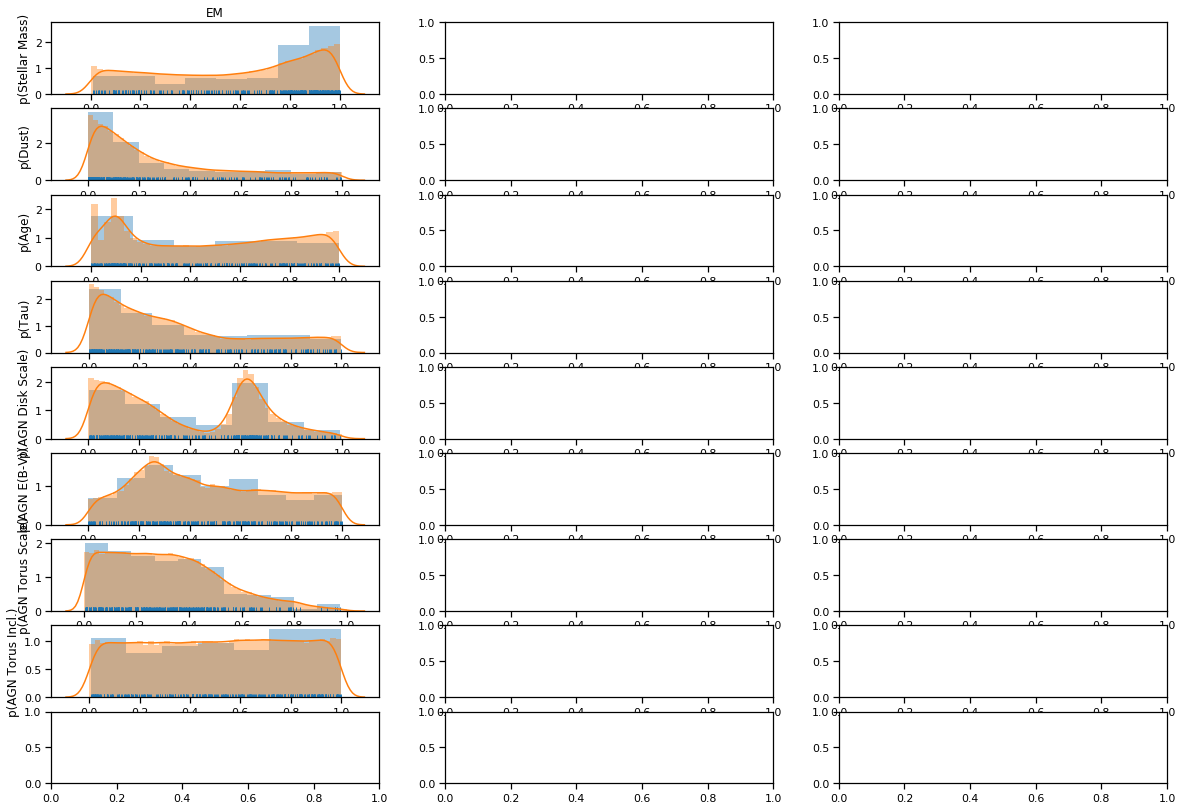

In [62]:
param_names = ['Stellar Mass', 'Dust', 'Age', 'Tau', 'AGN Disk Scale', 'AGN E(B-V)', 'AGN Torus Scale', 'AGN Torus Incl.', 'Scale']

fig, axes = plt.subplots(ncols=len(pairs), nrows=9, figsize=(20, 14))
for pair_n, pair in enumerate(pairs):
    print(pair_n)  # for progress
    for param_n, param in enumerate(param_names):

        if param_n < 8:  # temporary, naive doesn't have sampled or true scale recorded yet
        
            sample_list = pair[0]
            samples = np.concatenate(sample_list, axis=0)
    #         print(samples.shape)
            relevant_samples = samples[:, param_n]  # no chain dim

            true_param_values = pair[1][:, param_n]

            ax=axes[param_n, pair_n]  # row, column convention
            sns.distplot(true_param_values, ax=ax, kde=False, norm_hist=True, rug=True)
            sns.distplot(relevant_samples, ax=ax, norm_hist=True)
            ax.set_xlabel(param)
            ax.set_ylabel(f'p({param})')
            if param_n == 0:
                ax.set_title(titles[pair_n])
fig.tight_layout()

In [63]:
# def plot_single_coverage(posteriors, true_params):
#     fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharex=True, sharey=True)
#     all_axes = [ax for row in axes for ax in row]
#     params = ['Stellar Mass', 'Dust', 'Age', 'Tau', 'AGN Disk Scale', 'AGN E(B-V)', 'AGN Torus Scale', 'AGN Torus Incl.']
#     for param_n in range(8):
#         ax = all_axes[param_n]
#         ax.plot([0, 1.], [0, 1.], 'k--')
#         ax.set_xlabel('Expected Rate')
#         ax.set_ylabel('Observed Rate')
#         ax.set_title(params[param_n])
        
#         if posteriors_all_params_hmc is not None:
#             subplot_coverage(posteriors_all_params_hmc, true_params_hmc, ax, param_n, label='hmc')
#         if posteriors_all_params_emcee is not None:
#             subplot_coverage(posteriors_all_params_emcee, true_params_emcee, ax, param_n, label='emcee')
#         if posteriors_all_params_emcee is not None:
#             subplot_coverage(posteriors_all_params_naive, true_params_naive, ax, param_n, label='naive')

#     for ax_n, ax in enumerate(all_axes):
#         if ax_n >= len(params):
#             ax.remove()

#     fig.legend(['Perfect', 'HMC', 'EM-NN', 'EM'], loc=[0.78, 0.15])
#     fig.tight_layout()
#     fig.savefig('notebooks/inference/latest_coverage.pdf')

In [75]:
def plot_all_coverages(posteriors_all_params_hmc, true_params_hmc, posteriors_all_params_emcee, true_params_emcee, posteriors_all_params_naive, true_params_naive):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharex=True, sharey=True)
    all_axes = [ax for row in axes for ax in row]
    params = ['Stellar Mass', 'Dust', 'Age', 'Tau', 'AGN Disk Scale', 'AGN E(B-V)', 'AGN Torus Scale', 'AGN Torus Incl.']
    for param_n in range(8):
        ax = all_axes[param_n]
        ax.plot([0, 1.], [0, 1.], 'k--')
        ax.set_xlabel('Expected Rate')
        ax.set_ylabel('Observed Rate')
        ax.set_title(params[param_n])

        if posteriors_all_params_hmc is not None:
            subplot_coverage(posteriors_all_params_hmc, true_params_hmc, ax, param_n, label='hmc')
        if posteriors_all_params_emcee is not None:
            subplot_coverage(posteriors_all_params_emcee, true_params_emcee, ax, param_n, label='emcee')
        if posteriors_all_params_naive is not None:
            print('Naive')
            subplot_coverage(posteriors_all_params_naive, true_params_naive, ax, param_n, label='naive')

    for ax_n, ax in enumerate(all_axes):
        if ax_n >= len(params):
            ax.remove()

    fig.legend(['Perfect', 'HMC', 'EM-NN', 'EM'], loc=[0.78, 0.15])
    fig.tight_layout()
    fig.savefig('notebooks/inference/latest_coverage.pdf')

In [76]:
def subplot_coverage(posteriors_all_params, true_params, ax, param_n, label):
        # select for param_n
        true_values = true_params[:, param_n]
        posteriors = [gal[:, param_n] for gal in posteriors_all_params]  # galaxy, samples (flat), params
        
        # filter as needed
#         wide_enough = np.array([x.std() < 0.2 for x in posteriors])
#         not_tiny = np.array([x.std() > 0.01 for x in posteriors])
#         good_width = wide_enough & not_tiny
#         good_width = wide_enough
#         print(len(posteriors))
#         posteriors = [x for n, x in enumerate(posteriors) if good_width[n]]
#         true_values = true_values[wide_enough]
        
        print(len(posteriors))
#         print(len(true_values))
#         print(posteriors[0].shape)
        if len(posteriors) < 5:
            return None  # don't try to calculate coverage

        df = get_coverage(posteriors, true_values)
        coverage = aggregate_coverage_df(df)
        ax.plot(coverage['ci_width'], coverage['observed_rate'])
        ax.fill_between(x=coverage['ci_width'], y1=coverage['observed_rate_min'], y2=coverage['observed_rate_max'], alpha=0.5, label=label)
#         ax.legend()

Begin
Naive
310


 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:Mean of empty slice.
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:invalid value encountered in double_scalars


Begin
Naive
310


 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:Mean of empty slice.
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:invalid value encountered in double_scalars


Begin
Naive
310


 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:Mean of empty slice.
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:invalid value encountered in double_scalars


Begin
Naive
310


 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:Mean of empty slice.
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:invalid value encountered in double_scalars


Begin
Naive
310


 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:Mean of empty slice.
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:invalid value encountered in double_scalars


Begin
Naive
310


 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:Mean of empty slice.
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:invalid value encountered in double_scalars


Begin
Naive
310


 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:Mean of empty slice.
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:invalid value encountered in double_scalars


Begin
Naive
310


 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:Mean of empty slice.
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:invalid value encountered in double_scalars


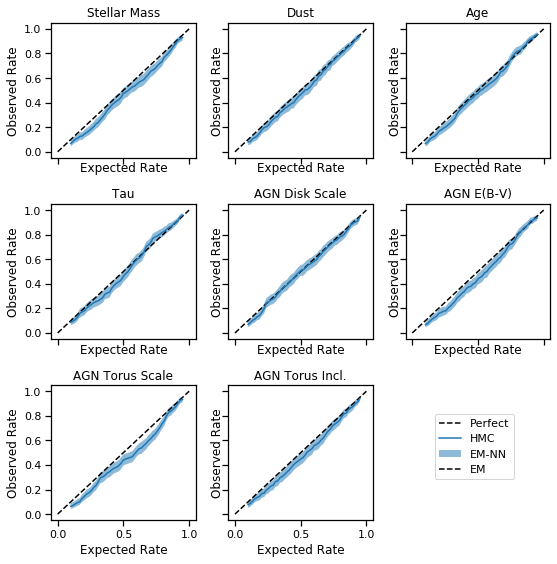

In [77]:
# plot_all_coverages(None, None, None, None, posteriors_all_params_naive, true_params_naive)
plot_all_coverages(posteriors_all_params_hmc, true_params_hmc, posteriors_all_params_emcee, true_params_emcee, posteriors_all_params_naive, true_params_naive)

In [78]:
# plot_all_coverages(posteriors_all_params_hmc, true_params_hmc, None, None)

In [ ]:
def plot_all_error_coverages(posteriors_all_params_hmc, true_params_hmc, posteriors_all_params_emcee, true_params_emcee):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharex=True, sharey=True)
    all_axes = [ax for row in axes for ax in row]
    params = ['Stellar Mass', 'Dust', 'Age', 'Tau', 'AGN Disk Scale', 'AGN E(B-V)', 'AGN Torus Scale', 'AGN Torus Incl.']
    for param_n in range(8):
        ax = all_axes[param_n]
#         ax.plot([0, 1.], [0, 1.], 'k--')
        ax.set_title(params[param_n])
        
        if true_params_hmc is not None:
            plot_hmc(true_params_hmc, posteriors_all_params_hmc, ax, param_n)
        if true_params_emcee is not None:
            plot_emcee(true_params_emcee, posteriors_all_params_emcee, ax, param_n)

        ax.set_xlabel('Max Error')
        ax.set_ylabel('Truth Within Max Error')
# This the same as my manual version below
#         coverage = aggregate_coverage_df(df)
#         ax.plot(coverage['ci_width'], coverage['observed_rate'])
#         ax.fill_between(x=coverage['ci_width'], y1=coverage['observed_rate_min'], y2=coverage['observed_rate_max'], alpha=0.5)

    for ax_n, ax in enumerate(all_axes):
        if ax_n >= len(params):
            ax.remove()
    fig.tight_layout()

In [ ]:
def plot_hmc(true_params, posteriors_all_params, ax, param_n):
    # select for param_n
    true_values = true_params[:, param_n]
    posteriors = [gal[:, param_n] for gal in posteriors_all_params]  # galaxy, samples (flat), params

    print(len(posteriors))
    if len(posteriors) < 5:
        return None

    df = get_error_coverage(posteriors, true_values)
    sns.lineplot(data=df, x='error', y='true_is_within', ax=ax, ci=90, label='True')
    sns.lineplot(data=df, x='error', y='posterior_frac', ax=ax, ci=90, label='Expected (HMC)')
    

In [ ]:
def plot_emcee(true_params, posteriors_all_params, ax, param_n):
    # select for param_n
    true_values = true_params[:, param_n]
    posteriors = [gal[:, param_n] for gal in posteriors_all_params]  # galaxy, samples (flat), params

    # filter as needed TODO
    print(len(posteriors))
    if len(posteriors) < 5:
        return None  # don't try to calculate coverage

    df = get_error_coverage(posteriors, true_values)
    sns.lineplot(data=df, x='error', y='true_is_within', ax=ax, ci=90, label='True (EM-NN)')
#     sns.lineplot(data=df, x='error', y='posterior_frac', ax=ax, ci=90, label='Expected (EM-NN)')

In [ ]:
plot_all_error_coverages(
    posteriors_all_params_hmc=posteriors_all_params_hmc,
    true_params_hmc=true_params_hmc,
    posteriors_all_params_emcee=posteriors_all_params_emcee,
    true_params_emcee=true_params_emcee
)

In [ ]:
plot_all_error_coverages(
    posteriors_all_params_hmc=posteriors_all_params_hmc,
    true_params_hmc=true_params_hmc,
    posteriors_all_params_emcee=None,
    true_params_emcee=None
)

In [ ]:
true_params_hmc.shape

In [ ]:
help(sns.distplot)

In [ ]:
posterior_records, param_bins = parameter_recovery.get_all_posterior_records(marginals, true_params, n_param_bins=n_param_bins, n_posterior_bins=n_posterior_bins)

In [ ]:
posterior_records[0].shape

In [ ]:
plt.plot(posterior_records[0][10])

In [ ]:
posterior_record = posterior_records[0]
posterior = posterior_record[20]
param_values = np.arange(len(posterior))


In [ ]:
samples.shape

In [ ]:
true_params[0, 0]

In [ ]:
az.hpd(samples[0, :, 0])

In [ ]:
# group samples wit

In [ ]:
dummy_array = np.zeros(42)  # anything
n_param_bins = 10
_, param_bins = np.histogram(dummy_array, range=(0., 1.), bins=n_param_bins)
param_bins.shape

In [ ]:
bin_centers = param_bins[1:] + (param_bins[0:-1] - param_bins[1:]) / 2

In [ ]:
bin_centers.shape

In [ ]:
samples.shape

In [ ]:
samples_by_truth = [[] for n in range(len(bin_centers))]

which_param = 0  # mass
for galaxy_n in range(len(samples)):
    true_param = true_params[galaxy_n, which_param]
    true_param_index = np.digitize(true_param, param_bins) - 1
#     print(true_param_index)
    samples_by_truth[true_param_index].append(np.squeeze(samples[galaxy_n, :, which_param]))
# samples_by_truth = np.array(samples_by_truth)

for n in range(len(samples_by_truth)):
    samples_by_truth[n] = np.array(samples_by_truth[n]).flatten()

In [ ]:
az.hpd

In [ ]:
[x.shape for x in samples_by_truth]

In [ ]:
az.hpd(np.arange(1000))

In [ ]:
bounds_by_truth = np.array([get_hpd(x) for x in samples_by_truth])
medians = np.array([np.median(x) for x in samples_by_truth])

In [ ]:
# bounds_by_truth[:, 0]

In [ ]:
# bounds_by_truth[:, 1] - bounds_by_truth[:, 0]

In [ ]:
plt.plot(bounds_by_truth)
plt.plot(medians)

In [ ]:
delta_bounds_by_truth = bounds_by_truth.copy().transpose()
delta_bounds_by_truth[1, :] = delta_bounds_by_truth[1, :] - medians
delta_bounds_by_truth[0, :] = medians - delta_bounds_by_truth[0, :]

In [ ]:
# plt.plot(delta_bounds_by_truth.transpose())

In [ ]:
plt.errorbar(bin_centers, medians, yerr=delta_bounds_by_truth, linestyle='', marker='+')

In [ ]:
plt.fill_between(bin_centers, bounds_by_truth[:, 0], bounds_by_truth[:, 1], alpha=0.5)
plt.plot(bin_centers, bin_centers, linestyle='--', color='k')

In [ ]:
def get_bounds(posterior, bin_centers, ci=0.9):
    missing = np.isnan(posterior)
    p = posterior[~missing]
#     param_values = param_values[~missing]
    centers = bin_centers[~missing]
    if len(centers) == 0:
        return np.array([np.nan, np.nan])
    samples = np.random.choice(centers, p=p/p.sum(), size=800000)
    return az.hpd(samples, credible_interval=ci)

In [ ]:
bounds = np.array([get_bounds(posterior, bin_centers) for posterior in posterior_record])

In [ ]:
bounds.shape

In [ ]:
plt.scatter(bin_centers, bounds[:, 0])
plt.scatter(bin_centers, bounds[:, 1])